In [8]:
import pandas as pd
import json
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
import joblib

data = {}

def load_json(file_path):
    with open(file_path, 'r', encoding="utf-8") as file:
        return json.load(file)


def preprocess_token_data(data: dict) -> pd.DataFrame:
    records = []
    for mint, token in data.items():
        for price_change in token.get("marketCapHistory", []):
            timestamp = price_change.get("timestamp")
            if timestamp > 10*10:
                timestamp = timestamp/1000
            records.append({
                "timestamp": timestamp,
                "marketCap": price_change.get("marketCap", 0),
                "symbol": token.get("symbol", "Unknown"),
                "volume": token.get("volume", 0),
                "numHolders": token.get("numHolders", 0),
                "sniperCount": token.get("sniperCount", 0),
                "progress": token.get("progress", 0),
                "buySellRatio": token.get("buySellRatio", 0),
                "liquidity": token.get("liquidity", 0),
                "volatility": token.get("volatility", 0)
            })

        for neo in token.get("Neo", []):
            records.append({
                "symbol": token.get("symbol", "Unknown"),
                "holderCounts": neo.get("holderCounts", 0),
                "tagsCount": neo.get("tagsCount", 0),
                "devHoldingSupplyPerc": neo.get("devHoldingSupplyPerc", 0),
                "insiderWalletsSupplyPerc": neo.get("insiderWalletsSupplyPerc", 0)
            })

        for trades in token.get("trades", []):
            records.append({
                "timestamp": trades.get("timestamp"),
                "symbol": token.get("symbol", "Unknown"),
                "solAmount": trades.get("solAmount", 0),
                "isBuy": trades.get("isBuy", 0),
            })

    return pd.DataFrame(records)


files = [
    'data/coiny_bez_limitu6.json',
    'data/coiny_bez_limitu7.json',
    'data/coiny_bez_limitu8.json',
    'data/coiny_bez_limitu9.json',
    'data/coiny_bez_limitu10.json',
    'data/coiny_bez_limitu11.json',
]

for file in files:
    data.update(load_json(file))

df = preprocess_token_data(data)
df

,timestamp,marketCap,symbol,volume,numHolders,sniperCount,progress,buySellRatio,liquidity,volatility,holderCounts,tagsCount,devHoldingSupplyPerc,insiderWalletsSupplyPerc,solAmount,isBuy
0,1.738860e+06,7887.522187,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1.738860e+06,7892.808009,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1.738860e+09,7885.040000,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1.738860e+06,7935.138594,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1.738860e+06,7973.608513,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409964,1.739034e+09,NaN,OFI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.500000e+09,True
409965,1.739034e+06,5432.958982,LCSE,0.0000,0.0,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
409966,1.739034e+09,NaN,LCSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.005390e+07,True
409967,1.739034e+06,5476.591540,ice,0.0000,0.0,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


# Converting data and creating new features

In [13]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df.sort_values(['symbol', 'timestamp'], inplace=True)

df['marketCap_change'] = df.groupby('symbol')['marketCap'].pct_change().fillna(0)
df['marketCap_ema'] = df.groupby('symbol')['marketCap'].transform(lambda x: x.ewm(span=7).mean())
df['rsi'] = df.groupby('symbol')['marketCap'].transform(lambda x:
    100 - (100 / (1 + x.pct_change().fillna(0).rolling(window=7).mean() / x.pct_change().fillna(0).rolling(window=7).std())))

df['marketCap_change_ratio'] = (df['marketCap'] - df['marketCap'].shift(1)) / df['marketCap'].shift(1)
df['holders_growth'] = df['numHolders'].diff().fillna(0)
df['volatility_to_volume_ratio'] = df['volatility'] / (df['volume'] + 1)

## Normalization
scaler = StandardScaler()
features_to_scale = ['marketCap', 'volume', 'numHolders', 'volatility']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

df

,timestamp,marketCap,symbol,volume,numHolders,sniperCount,progress,buySellRatio,liquidity,volatility,...,devHoldingSupplyPerc,insiderWalletsSupplyPerc,solAmount,isBuy,marketCap_change,marketCap_ema,rsi,marketCap_change_ratio,holders_growth,volatility_to_volume_ratio
120353,1970-01-01 00:00:00.001738867,-0.684289,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.000000,-0.684289,NaN,NaN,0.0,0.0
120354,1970-01-01 00:00:00.001738867,-0.684289,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.000000,-0.684289,NaN,-0.000000,0.0,0.0
120356,1970-01-01 00:00:00.001738867,-0.696512,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.017862,-0.689574,NaN,0.017862,0.0,0.0
120357,1970-01-01 00:00:00.001738867,-0.696512,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.000000,-0.692111,NaN,-0.000000,0.0,0.0
120358,1970-01-01 00:00:00.001738867,-0.696512,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.000000,-0.693554,NaN,-0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124134,1970-01-01 00:00:01.738868202,NaN,🪦,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,20000000.0,True,0.000000,-0.710517,NaN,NaN,0.0,NaN
124135,1970-01-01 00:00:01.738868202,NaN,🪦,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,225143630.0,False,0.000000,-0.710517,NaN,NaN,0.0,NaN
124130,1970-01-01 00:00:01.738868203,-0.727690,🪦,-0.348167,-0.486215,7.0,0.09,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.027230,-0.727232,27.429189,NaN,0.0,0.0
123649,NaT,NaN,🪦,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.1095,0.0,NaN,NaN,0.000000,-0.727232,27.429189,NaN,0.0,NaN


# Investment label function
  - assigns labels to investment opportunities based on market capitalization growth over different time windows (7, 15, and 30)
  - if the coin grows more than 50% in the time windows, the group is labeled as 1 (a signal to buy)

In [23]:
def label_investment(group) -> pd.Series:
    time_windows = [7, 15, 30]

    labels = pd.Series(0, index=group.index)

    if len(group) < min(time_windows):
        return labels

    initial_market_cap = group['marketCap'].iloc[0]

    for window in time_windows:
        if len(group) >= window:
            max_growth = (group['marketCap'].iloc[:window].max() - initial_market_cap) / (initial_market_cap + 1e-6)
            if max_growth > 0.50:
                labels[:] = 1
                break

    return labels


df['label'] = df.groupby('symbol', group_keys=False).apply(label_investment)
df.fillna(0, inplace=True)

features = ['marketCap_change', 'marketCap_ema', 'rsi', 'marketCap_change_ratio', 'holders_growth', 'volatility_to_volume_ratio']
X = df[features]
y = df['label']

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

joblib.dump(features, 'features.joblib')

df['label'].value_counts()

label
0    381399
1     28570
Name: count, dtype: int64

In [24]:
smote = SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, stratify=y_resampled, random_state=42)

print(y_train.value_counts())
print(y_test.value_counts())

label
0    305119
1    152559
Name: count, dtype: int64
label
0    76280
1    38140
Name: count, dtype: int64


In [29]:
import xgboost as xgb
import optuna
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, log_loss, f1_score
)


def objective(trial):
        params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 10, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.8, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2, 8),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 5),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 1500),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'max_delta_step': trial.suggest_int('max_delta_step', 2, 10),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'device': 'gpu'
        }

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        f1_scores = []

        X_np = X_train.to_numpy() if hasattr(X_train, "to_numpy") else X_train
        y_np = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train

        for train_idx, val_idx in skf.split(X_np, y_np):
            X_tr, X_val = X_np[train_idx], X_np[val_idx]
            y_tr, y_val = y_np[train_idx], y_np[val_idx]

            model = xgb.XGBClassifier(**params)
            model.fit(X_tr, y_tr)

            y_pred = model.predict(X_val)
            f1_scores.append(f1_score(y_val, y_pred, average='macro'))

        return np.mean(f1_scores)

optimized_params = {
    'max_depth': 14,
    'learning_rate': 0.065,
    'subsample': 0.65,
    'colsample_bytree': 0.82,
    'colsample_bylevel': 0.95,
    'reg_lambda': 1.0,
    'reg_alpha': 1.0,
    'n_estimators': 1100,
    'min_child_weight': 2,
    'gamma': 0.5,
    'max_delta_step': 4,
    'grow_policy': 'depthwise',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'device': 'gpu'
}


# Run Optimized Optuna Tuning
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=120)
#
# # Get Best Hyperparameters
# best_params = study.best_params
# best_params['objective'] = 'binary:logistic'
# best_params['eval_metric'] = 'logloss'
# best_params['device'] = 'gpu'
#
# print("Best Hyperparameters for 90%+ F1:", best_params)

#Train Final Model with Best Params
# **best_params uses params from hyperparametr tunning
final_model = xgb.XGBClassifier(**optimized_params)
eval_set = [(X_train, y_train), (X_test, y_test)]
final_model.fit(X_train, y_train, eval_set=eval_set)

# Make Predictions
y_pred_probs = final_model.predict_proba(X_test)[:, 1]
optimal_threshold = 0.5
y_pred = (y_pred_probs > optimal_threshold).astype(int)

print("Updated Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
logloss = log_loss(y_test, y_pred_probs)
print(f"Log Loss: {logloss}")

final_model.save_model("crypto_investment_model.json")

[0]	validation_0-logloss:0.61206	validation_1-logloss:0.61223
[1]	validation_0-logloss:0.59106	validation_1-logloss:0.59135
[2]	validation_0-logloss:0.57560	validation_1-logloss:0.57588
[3]	validation_0-logloss:0.57405	validation_1-logloss:0.57433
[4]	validation_0-logloss:0.55381	validation_1-logloss:0.55458
[5]	validation_0-logloss:0.55114	validation_1-logloss:0.55209
[6]	validation_0-logloss:0.53382	validation_1-logloss:0.53524
[7]	validation_0-logloss:0.52099	validation_1-logloss:0.52255
[8]	validation_0-logloss:0.51009	validation_1-logloss:0.51177
[9]	validation_0-logloss:0.49792	validation_1-logloss:0.50000
[10]	validation_0-logloss:0.48605	validation_1-logloss:0.48855
[11]	validation_0-logloss:0.48460	validation_1-logloss:0.48723
[12]	validation_0-logloss:0.48313	validation_1-logloss:0.48591
[13]	validation_0-logloss:0.47201	validation_1-logloss:0.47524
[14]	validation_0-logloss:0.47063	validation_1-logloss:0.47401
[15]	validation_0-logloss:0.46966	validation_1-logloss:0.47311
[1

# Model Evaluation - XGBoost Crypto Investment Classifier

## Training vs. Test Log Loss Over Time
  - This plot shows how the **log loss** metric evolves over training iterations
  - The **blue line (Train Log Loss)** represents how well the model fits the training data
  - The **orange line (Test Log Loss)** represents the model's performance on unseen data
  - If the gap between train and test is **too large**, the model is likely **overfitting**

## ROC Curve
- The **ROC Curve** helps measure the classifier’s ability to distinguish between classes.
- A **higher AUC (0.92 in this case)** indicates that the model performs well in distinguishing investments vs. non-investments
- The **closer the curve is to the top-left corner**, the better the classification

## Confusion Matrix
- Shows the breakdown of **true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN)**
- **Dark blue areas indicate high accuracy**.

## Train vs. Test Accuracy
- If **train accuracy is much higher than test accuracy**, this indicates **overfitting** (not in this case)

## Feature Importance
- This plot shows which features have the **most influence** on the model’s decision


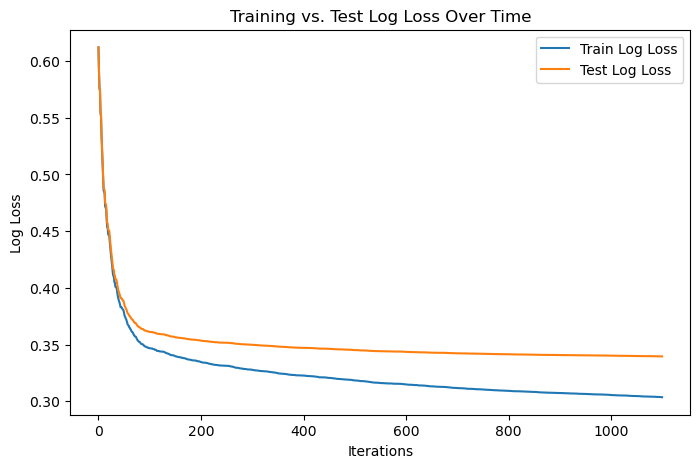

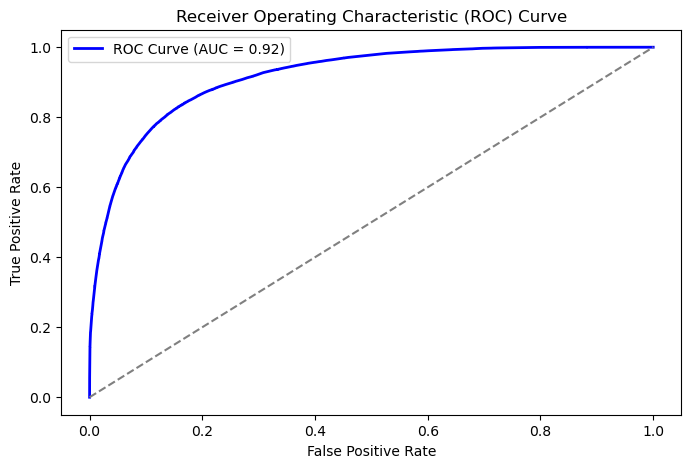

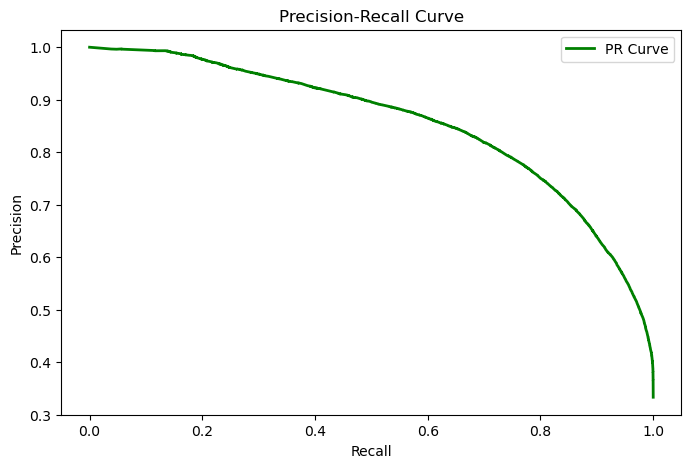

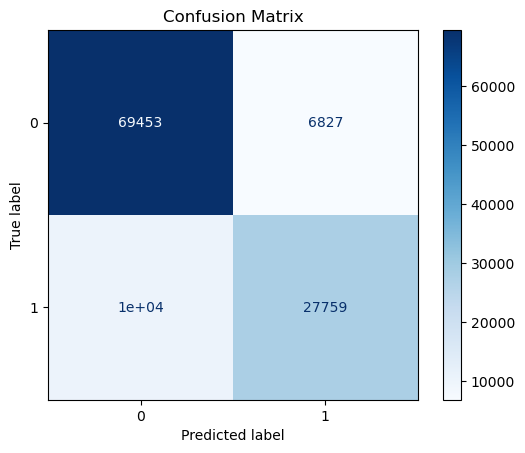

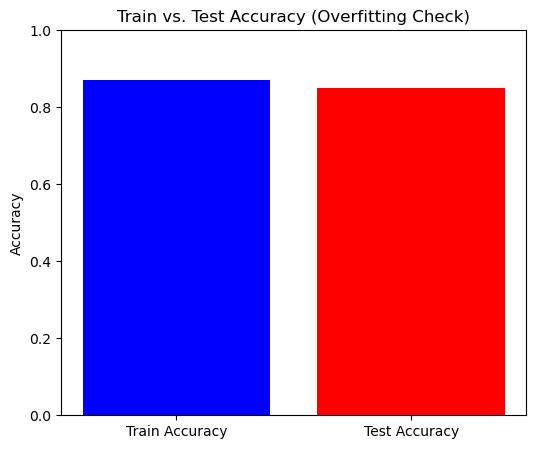

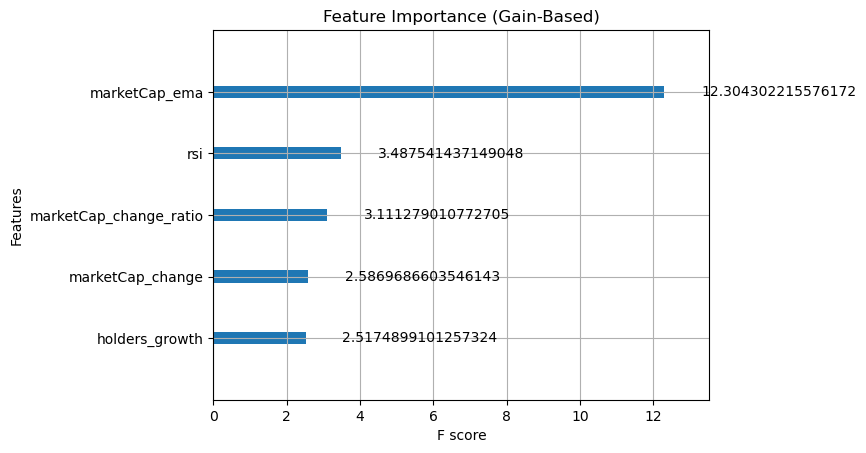

In [30]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

results = final_model.evals_result()
epochs = len(results["validation_0"]["logloss"])

plt.figure(figsize=(8,5))
plt.plot(range(epochs), results["validation_0"]["logloss"], label="Train Log Loss")
plt.plot(range(epochs), results["validation_1"]["logloss"], label="Test Log Loss")
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.title("Training vs. Test Log Loss Over Time")
plt.legend()
plt.show()

#ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

plt.figure(figsize=(8,5))
plt.plot(recall, precision, color="green", lw=2, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Train vs Test Accuracy (Overfitting Check)
train_acc = final_model.score(X_train, y_train)
test_acc = final_model.score(X_test, y_test)

plt.figure(figsize=(6,5))
plt.bar(["Train Accuracy", "Test Accuracy"], [train_acc, test_acc], color=["blue", "red"])
plt.ylabel("Accuracy")
plt.title("Train vs. Test Accuracy (Overfitting Check)")
plt.ylim(0, 1)
plt.show()

# Feature Importance (Gain-based)
xgb.plot_importance(final_model, importance_type='gain', title="Feature Importance (Gain-Based)")
plt.show()